In [1]:
import IPython.display as ipd

In [2]:
scale_fp = "./audio/scale.wav"
debussy_fp = "./audio/debussy.wav"
redhot_fp = "./audio/redhot.wav"
duke_fp = "./audio/duke.wav"

In [3]:
ipd.Audio(scale_fp)

## Loading audio files with torchcodec

In [4]:
from torchcodec.decoders import AudioDecoder

def get_samples(file_path):
    decoder = AudioDecoder(file_path, sample_rate=22050, num_channels=1)
    samples = decoder.get_all_samples()
    return samples.data, samples.sample_rate

In [5]:
y_scale, sr = get_samples(scale_fp)
y_debussy, _ = get_samples(debussy_fp)
y_redhot, _ = get_samples(redhot_fp)
y_duke, _ = get_samples(duke_fp)

## Extracting STFT with torch

In [6]:
FRAME_SIZE=2048
HOP_SIZE=512

In [7]:
import torch

s_scale = torch.stft(y_scale,                                   # must be 1D or 2D batch of time sequences
                     n_fft=FRAME_SIZE,                          # Basically the frame size
                     hop_length=HOP_SIZE,                       # If None, treated as n_fft//4
                     win_length=FRAME_SIZE,                     # If None, treated as n_fft
                     window=torch.hann_window(FRAME_SIZE),      # If None, rectangular window(Seriously torch?). Always explicitly specify the window. 
                     center=True,                               # Whether frames are centred at t X hop_length. True by default.
                     pad_mode='reflect',                        # Only used when center=True, controls the padding mode. By default, reflect padding. WHY?? Librosa uses constant padding which seems better?
                     onesided=True,                             # If input or window is complex, not possible. For real inputs and windows, returns N_FFT//2+1 bins in output
                     normalized=False,                          # Returns normalized STFT, i.e. divided by sqrt(frame_length). Librosa doesn't even provide this, but makes a lot of sense when used as feature.
                     return_complex=True)                       # Return complex tensor, or extra dim for real and imag components. 
print(s_scale.shape)
assert s_scale.size(-1) == torch.ceil(torch.tensor(y_scale.size(-1)/HOP_SIZE)).int()
print(s_scale.dtype)

torch.Size([1, 1025, 342])
torch.complex64


#### Some notes on STFT
- STFT output size is exclusively `torch.ceil(input.size(-1)/hop_length)`
- Unlike convolutions, it does not depend on `kernel_size` or `frame_size` here


## Magnitude Power Spectrogram

In [8]:
m_scale = torch.abs(s_scale)**2
print(m_scale.shape)
print(m_scale.dtype)

torch.Size([1, 1025, 342])
torch.float32


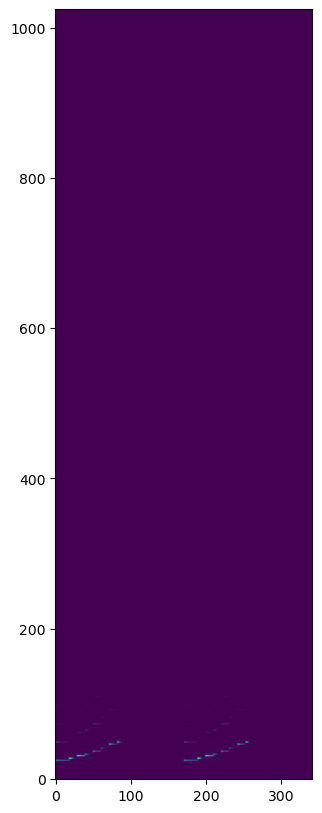

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))
plt.imshow(m_scale[0], origin='lower')
plt.show()

## Simple Log-Amplitude Spectrogram

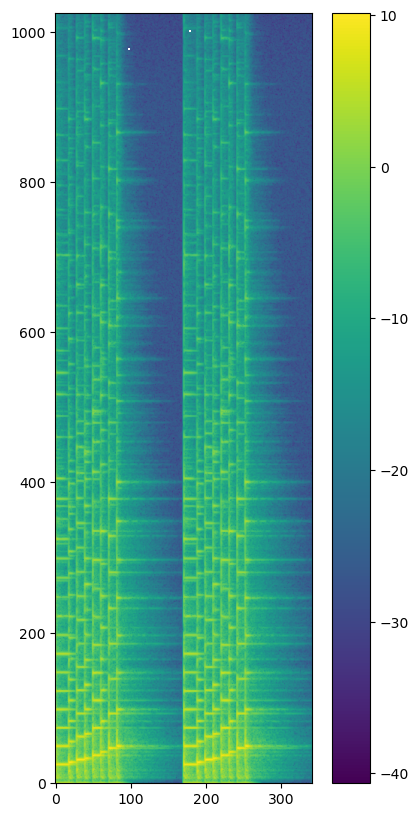

In [10]:
plt.figure(figsize=(5,10))
plt.imshow(torch.log(m_scale[0]), origin='lower')
plt.colorbar()
plt.show()

## Log Spectrogram with amplitude to dB conversion like librosa

In [11]:
import torchaudio.functional as AF
from math import log10

In [12]:
m_scale_db = AF.amplitude_to_DB(m_scale,                                            # Use absolute value for magnitude spectrogram
                               multiplier=10,                                      # Use 10 for power, 20 for amplitude
                               amin=1e-10,                                         # Librosa's default
                               db_multiplier=log10(max(1e-10, 1)),                 # defaults to 0, using librosa's default of ref=1
                               top_db=80.0 )                                       # Librosa's default

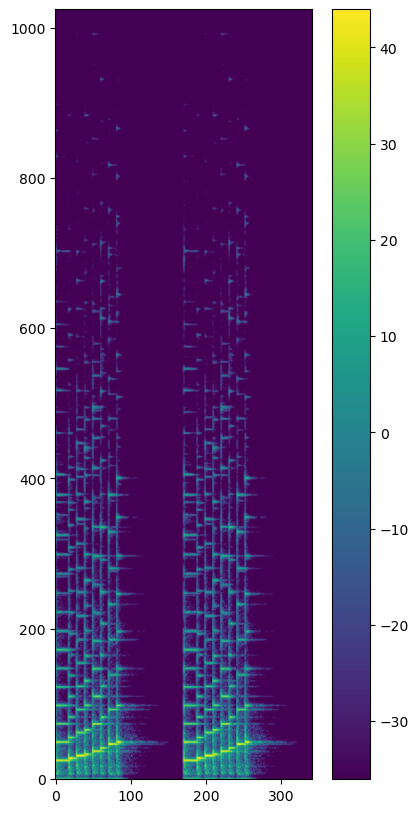

In [13]:
plt.figure(figsize=(5,10))
# plt.imshow(torch.log(m_scale[0]), origin='lower')
plt.imshow(m_scale_db[0], origin='lower')
plt.colorbar()
plt.show()

## Visualizing songs from different genres

In [14]:
import torch
import torchaudio.functional as AF
import matplotlib.pyplot as plt

def generate_and_plot_spectrogram(y):
    s = torch.stft(y,                                         # must be 1D or 2D batch of time sequences
                   n_fft=FRAME_SIZE,                          # Basically the frame size
                   hop_length=HOP_SIZE,                       # If None, treated as n_fft//4
                   win_length=FRAME_SIZE,                     # If None, treated as n_fft
                   window=torch.hann_window(FRAME_SIZE),      # If None, rectangular window(Seriously torch?). Always explicitly specify the window. 
                   center=True,                               # Whether frames are centred at t X hop_length. True by default.
                   pad_mode='reflect',                        # Only used when center=True, controls the padding mode. By default, reflect padding. WHY?? Librosa uses constant padding which seems better?
                   onesided=True,                             # If input or window is complex, not possible. For real inputs and windows, returns N_FFT//2+1 bins in output
                   normalized=False,                          # Returns normalized STFT, i.e. divided by sqrt(frame_length). Librosa doesn't even provide this, but makes a lot of sense when used as feature.
                   return_complex=True)                       # Return complex tensor, or extra dim for real and imag components. 

    m = torch.abs(s)**2

    m_db = AF.amplitude_to_DB(m,                                                  # Use absolute value for magnitude spectrogram
                              multiplier=10,                                      # Use 10 for power, 20 for amplitude
                              amin=1e-10,                                         # Librosa's default
                              db_multiplier=log10(max(1e-10, 1)),                 # defaults to 0, using librosa's default of ref=1
                              top_db=80.0 )                                       # Librosa's default
    
    # plt.figure(figsize=(10,10))
    plt.imshow(m_db[0], origin='lower')
    plt.colorbar()
    plt.show()

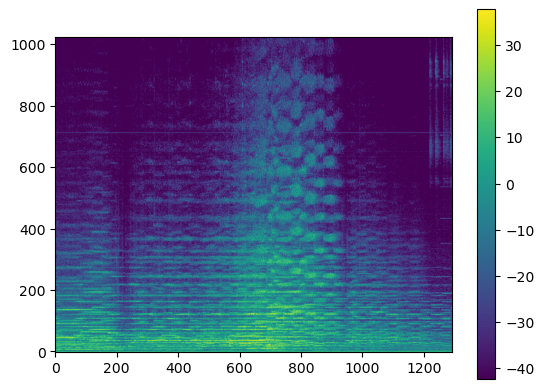

In [15]:
generate_and_plot_spectrogram(y_debussy)

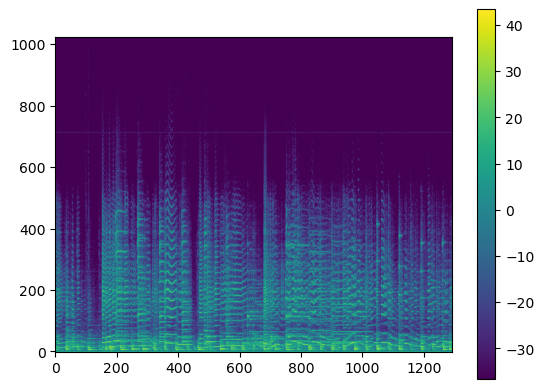

In [16]:
generate_and_plot_spectrogram(y_duke)

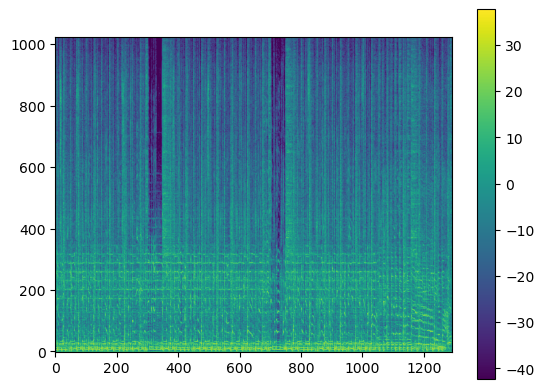

In [17]:
generate_and_plot_spectrogram(y_redhot)